In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Let's first take a look at our target variable:

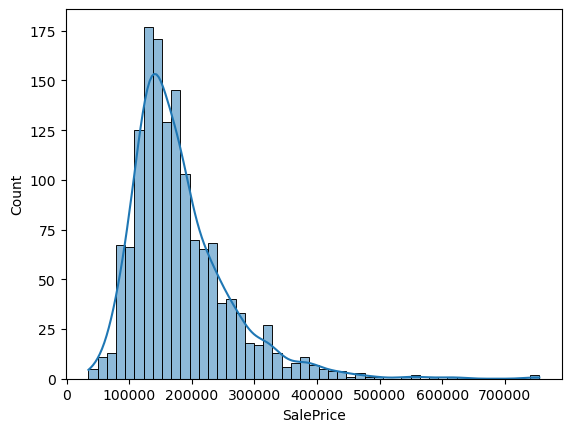

In [4]:
ax = sns.histplot(train_data["SalePrice"], kde=True)

It's clear that the distribution of SalePrice has a positive skew and is not exactly normal.

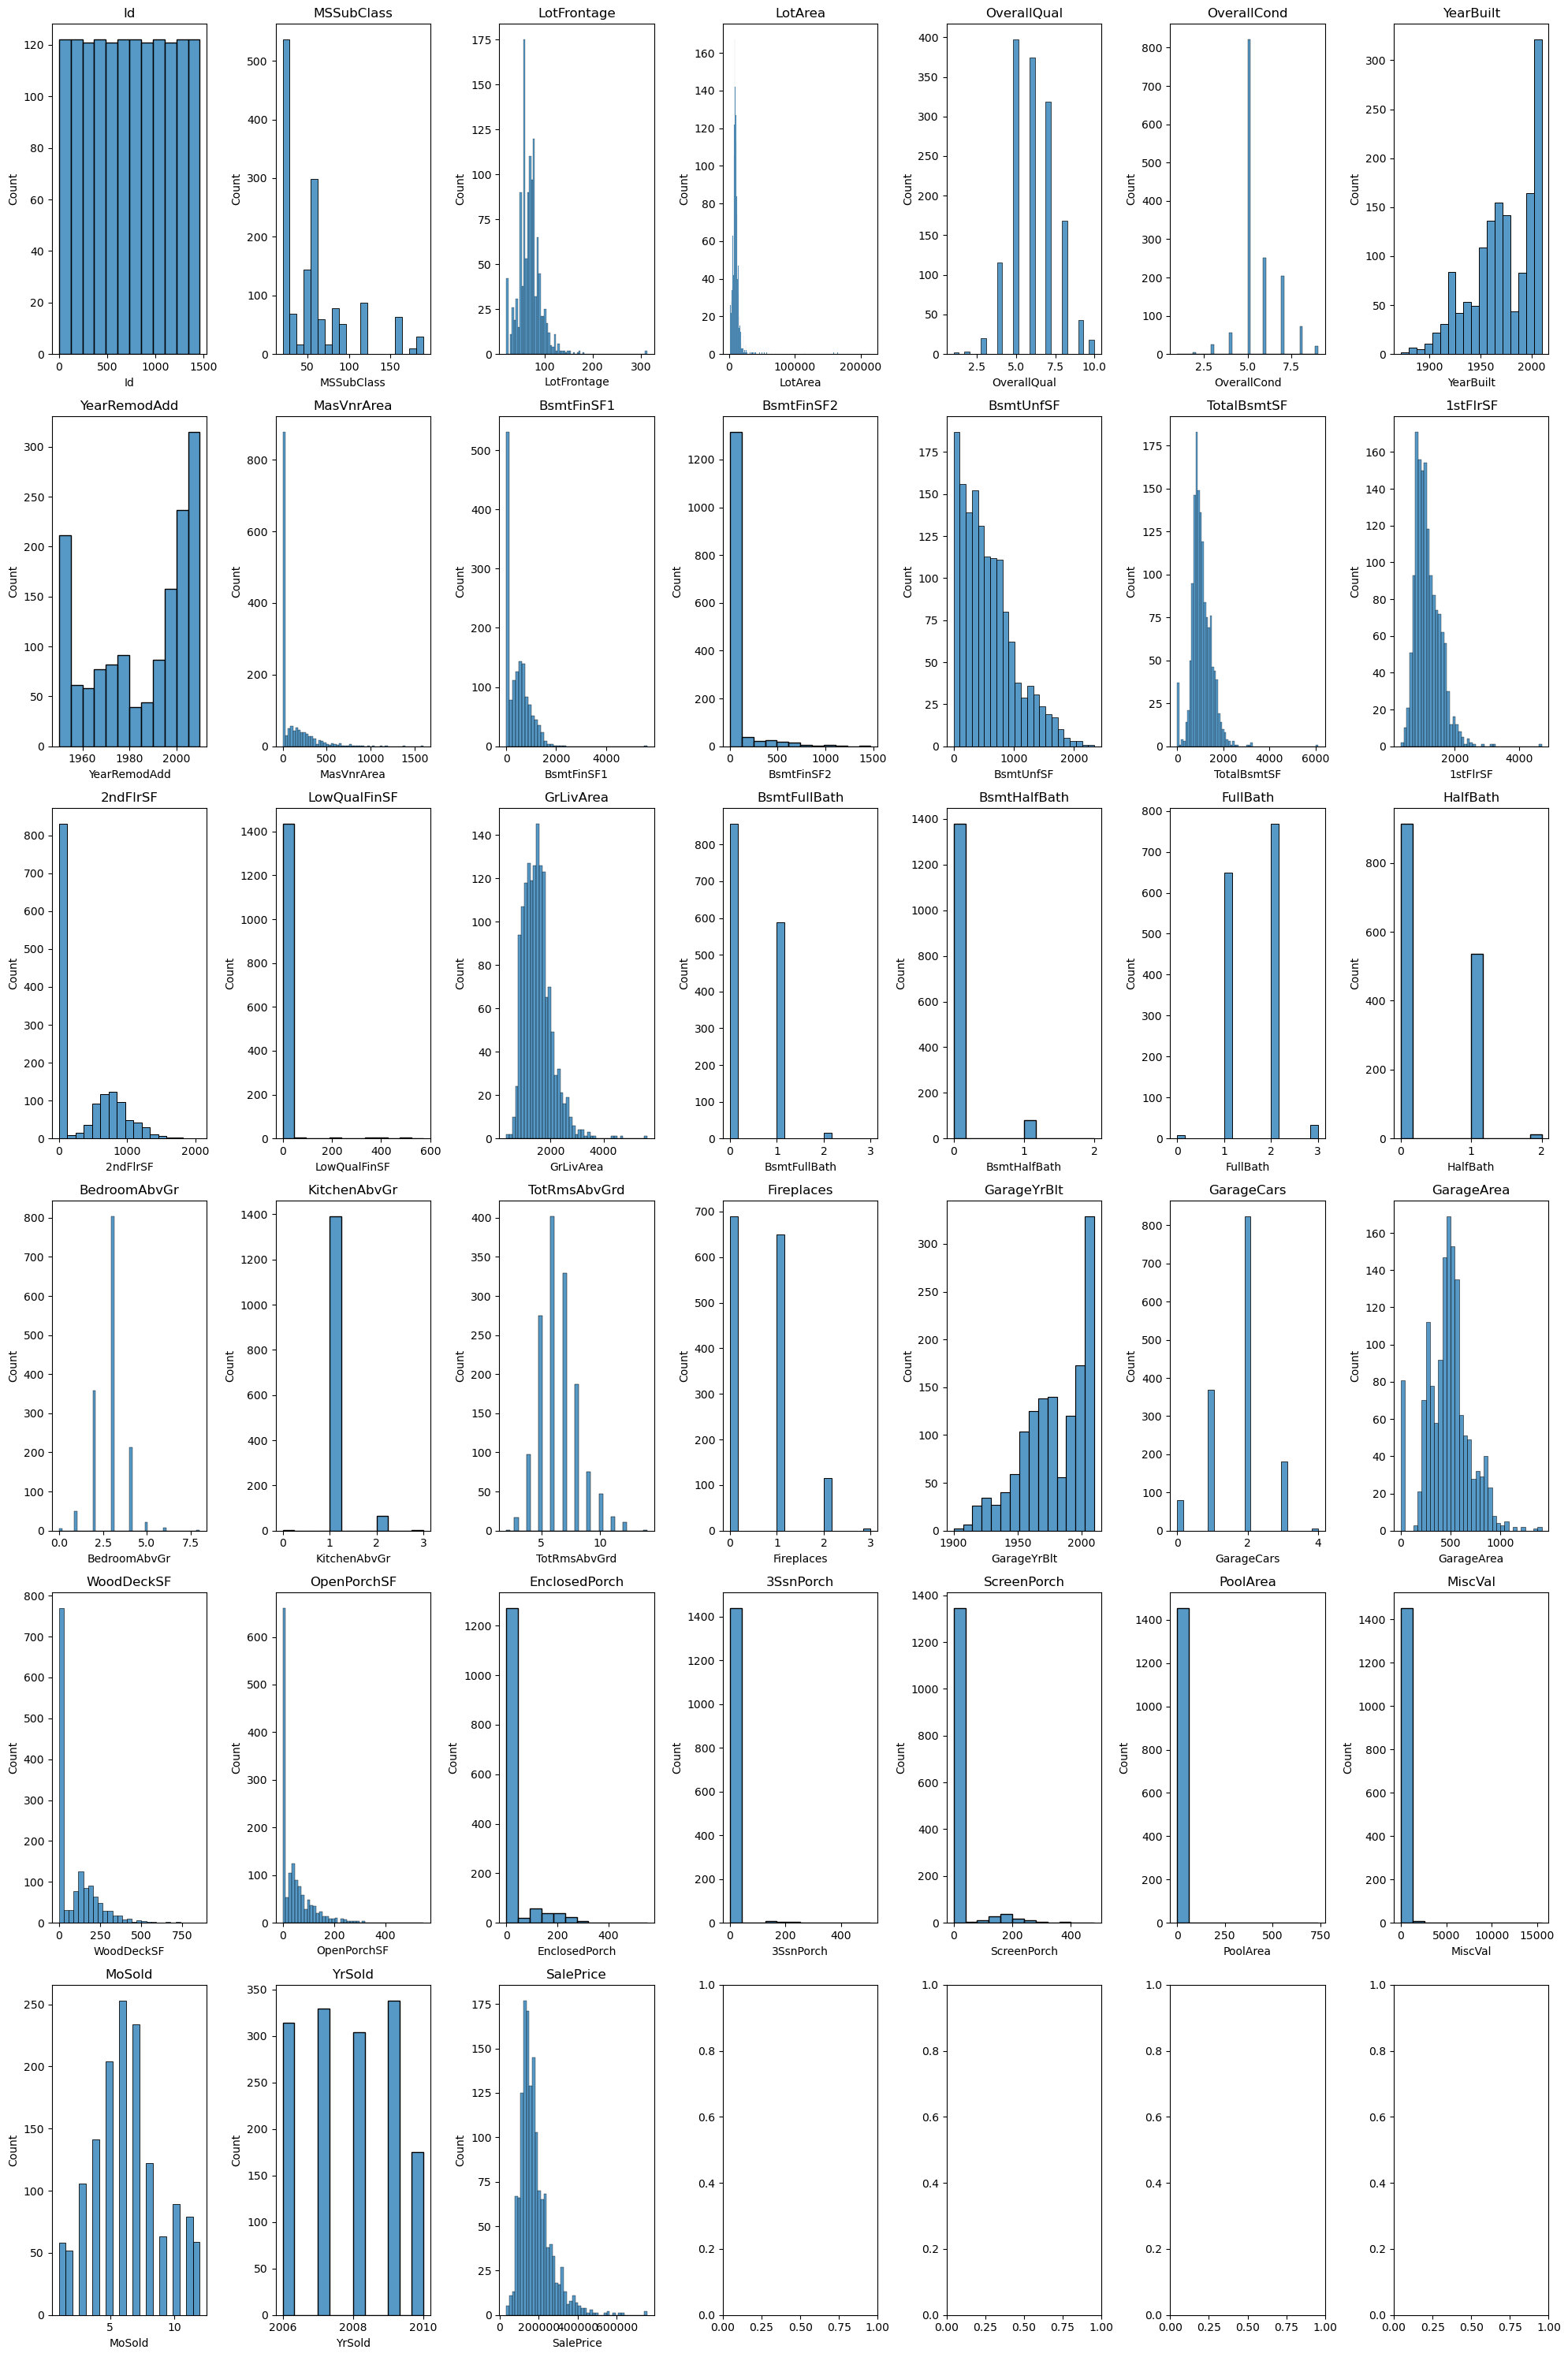

In [5]:
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
n_cols = int(np.ceil(len(numeric_columns) / 6))

fig, ax = plt.subplots(nrows=6, ncols=n_cols, figsize=(20,30), squeeze=False)
for i, col_name in enumerate(numeric_columns):
    row = i // n_cols
    col = i % n_cols
    sns.histplot(train_data[col_name], kde=False, ax=ax[row][col])
    ax[row][col].set_title(col_name)
plt.tight_layout()
plt.show()

Well, many variables are not normally distributed. Also, many of them seem to be count variables with discrete values. Some have very strong skew and kurtosis, while others have zero-inflated distributions. These facts are important to understand before fitting a model.

Let's also have a look at correlation matrix plots to see if we can spot some obvious or interesting correlations. We'll use Spearman correlation since most variables are not normally distributed.

<AxesSubplot: >

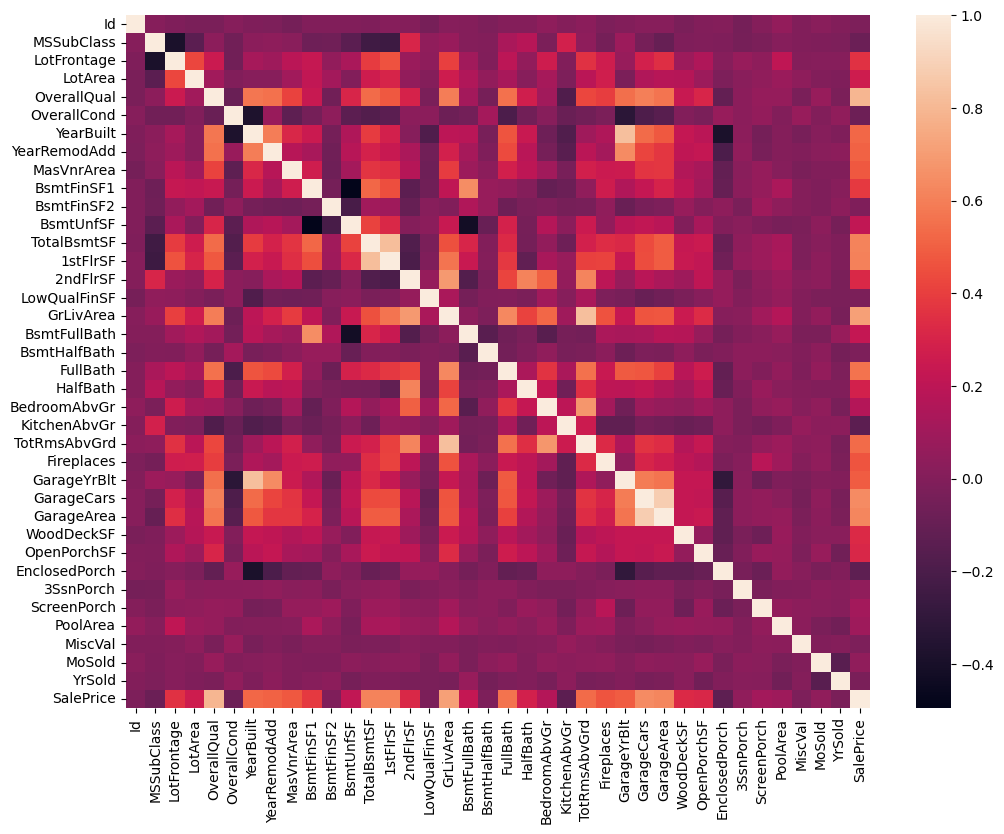

In [6]:
numeric_columns = train_data.select_dtypes(include=[np.number]).columns

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train_data[numeric_columns].corr())

Some variables seem to provide little extra information over others, for example, YearBuilt and GarageYrBlt. This means there is quite a lot of multicolinearity in the data. This is very relevant if we want to fit a linear model.

Let's finally take a look at the variables with the highest correlation with the target variable.

In [7]:
print(train_data[numeric_columns].corr()["SalePrice"].sort_values(ascending=False)[:20])

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64


Overall quality, ground living area, year built, garage capacity and the number of full bathrooms are the variables most correlated with the target variable.

One critical issue for our sale price predictor is (potentially) missing data. Let's take a look at it:

In [8]:
n_train = len(train_data)
all_data = pd.concat((train_data, test_data))
y_train = train_data["SalePrice"].values
all_data = all_data.drop(["SalePrice"], axis=1)


na_proportion = all_data.isnull().sum() / len(all_data) * 100
na_proportion = na_proportion.drop(na_proportion[na_proportion == 0].index)
na_proportion = na_proportion.sort_values(ascending=False)
na_proportion = pd.DataFrame({"NA proportion": na_proportion})
na_proportion.head(50)

,NA proportion
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageQual,5.447071
GarageCond,5.447071
GarageYrBlt,5.447071


According to the data description, many of those NA values are actually "not present" values. Therefore we can replace them:

In [9]:
fillna_cols = [
    "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "MasVnrType", "MSSubClass",
]

for col in fillna_cols:
    all_data[col] = all_data[col].fillna("None")

For the other variables, we'll use either the median/mean/mode or 0:

In [10]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)
all_data["GarageYrBlt"] = all_data["GarageYrBlt"].fillna(all_data["GarageYrBlt"].mean())

We could fill GarageYrBlt with 0 since there's no garage and, in practive, the variable is not defined. However, that would zero-inflate the variable and potentially distort its distribution - especially since years start at least in the 1800s range, making 0 a very strong outlier.

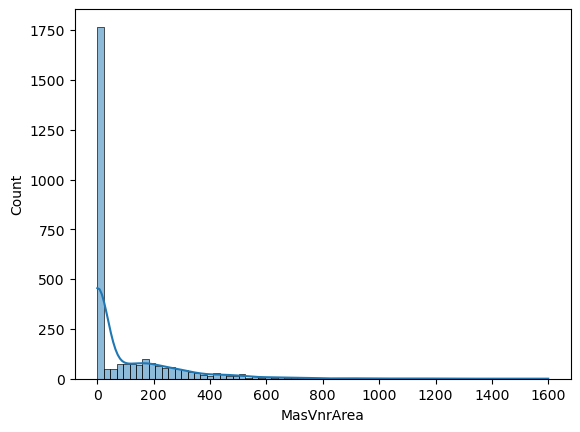

In [11]:
_ = sns.histplot(all_data["MasVnrArea"], kde=True)

MasVnrArea is already severely zero-inflated, so we'll fill the missing values with zero.

In [12]:
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [13]:
all_data["BsmtFullBath"] = all_data["BsmtFullBath"].fillna(all_data["BsmtFullBath"].mode()[0])
all_data["Utilities"] = all_data["Utilities"].fillna(all_data["Utilities"].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data["Functional"].mode()[0])
all_data["MSZoning"] = all_data["MSZoning"].fillna(all_data["MSZoning"].mode()[0])
all_data["Exterior1st"] = all_data["Exterior1st"].fillna(all_data["Exterior1st"].mode()[0])
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna(all_data["Exterior2nd"].mode()[0])
all_data["Electrical"] = all_data["Electrical"].fillna(all_data["Electrical"].mode()[0])
all_data["KitchenQual"] = all_data["KitchenQual"].fillna(all_data["KitchenQual"].mode()[0])
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])

In [14]:
for col in ("GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)

In [15]:
na_proportion = all_data.isnull().sum() / len(all_data) * 100
na_proportion = na_proportion.drop(na_proportion[na_proportion == 0].index)
na_proportion = na_proportion.sort_values(ascending=False)
na_proportion = pd.DataFrame({"NA proportion": na_proportion})
na_proportion.head(50)

,NA proportion


Many categorical variables have orders. Let's encode them in the correct order:

In [16]:
from category_encoders import OrdinalEncoder

col_mapping = [
    {
        "col": "FireplaceQu",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "BsmtQual",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "BsmtCond",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "GarageQual",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "GarageCond",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "ExterQual",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "ExterCond",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "HeatingQC",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "PoolQC",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "KitchenQual",
        "mapping": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    },
    {
        "col": "BsmtFinType1",
        "mapping": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "None"],
    },
    {
        "col": "BsmtFinType2",
        "mapping": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "None"],
    },
    {
        "col": "Functional",
        "mapping": ["Typ", "Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"],
    },
    {
        "col": "Fence",
        "mapping": ["GdPrv", "MnPrv", "GdWo", "MnWw", "None"],
    },
    {
        "col": "BsmtExposure",
        "mapping": ["Gd", "Av", "Mn", "No", "None"],
    },
    {
        "col": "GarageFinish",
        "mapping": ["Fin", "RFn", "Unf", "None"],
    },
    {
        "col": "LandSlope",
        "mapping": ["Gtl", "Mod", "Sev"],
    },
    {
        "col": "LotShape",
        "mapping": ["Reg", "IR1", "IR2", "IR3"],
    },
]

for mapping_dict in col_mapping:
    mapping_dict["mapping"] = {x: i for i, x in enumerate(mapping_dict["mapping"])}

ordinal_encoder = OrdinalEncoder(mapping=col_mapping)

ordinal_encoder.fit(all_data)
all_data_encoded = ordinal_encoder.transform(all_data)

Let's now take a look at some continuous variables and whether they are normally distributed or not. We'll only transform continuous variables that are skewed and are not too much zero-inflated.

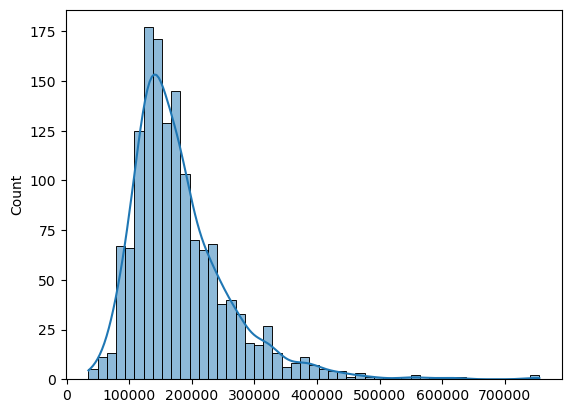

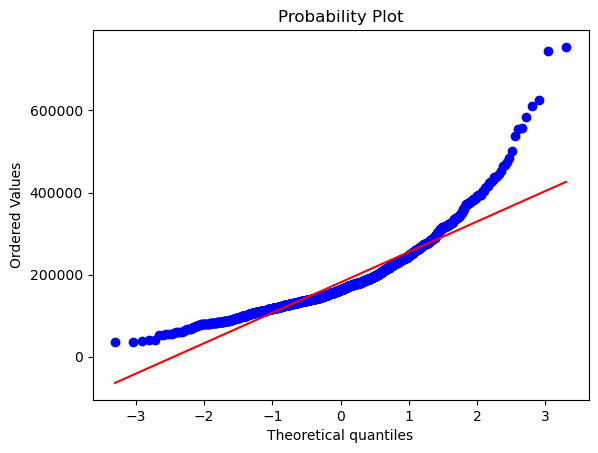

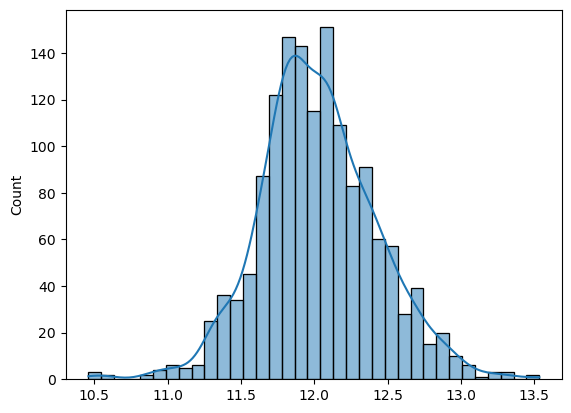

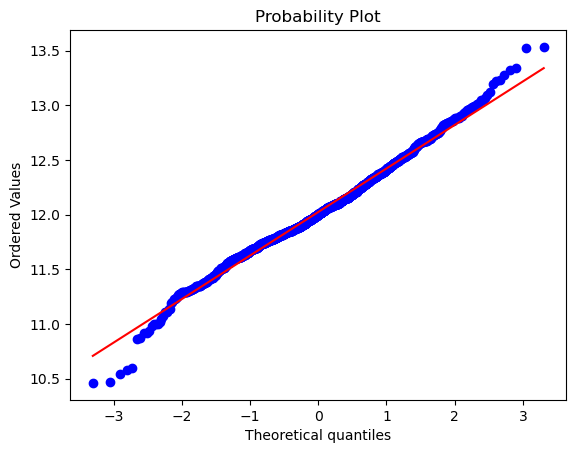

In [17]:
from scipy import stats

ax = sns.histplot(y_train, kde=True)
plt.show()
ax = stats.probplot(y_train, plot=plt)
plt.show()

y_train_log = np.log(y_train)

ax = sns.histplot(y_train_log, kde=True)
plt.show()
ax = stats.probplot(y_train_log, plot=plt)
plt.show()

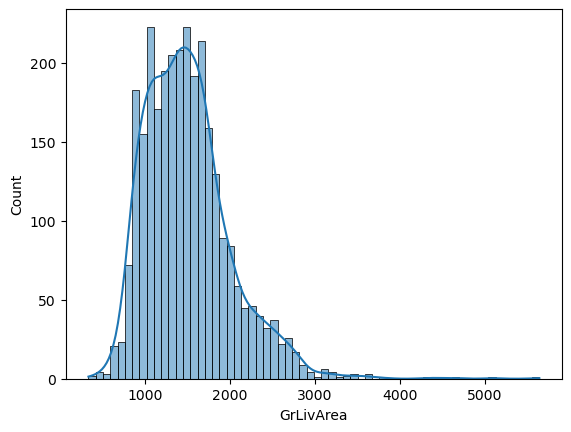

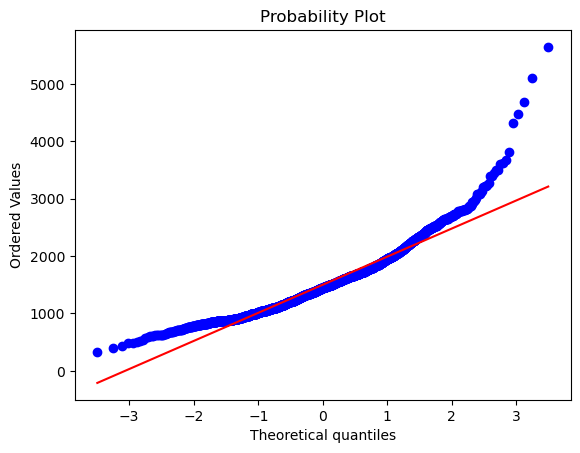

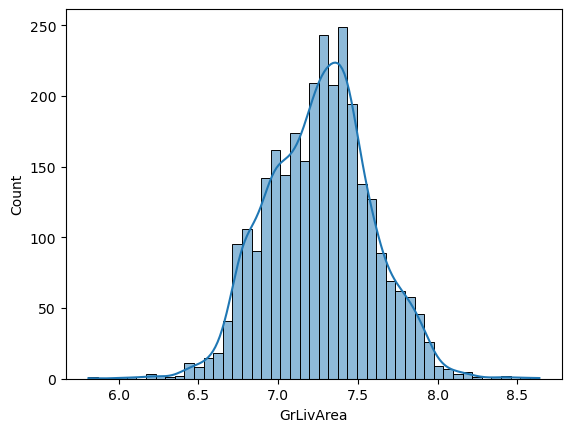

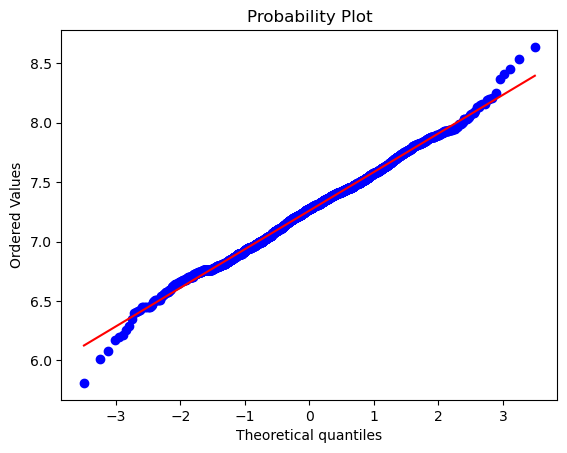

In [18]:
ax = sns.histplot(all_data["GrLivArea"], kde=True)
plt.show()
ax = stats.probplot(all_data["GrLivArea"], plot=plt)
plt.show()

# apply log transform

all_data["GrLivArea"] = np.log(all_data["GrLivArea"])
ax = sns.histplot(all_data["GrLivArea"], kde=True)
plt.show()
ax = stats.probplot(all_data["GrLivArea"], plot=plt)
plt.show()

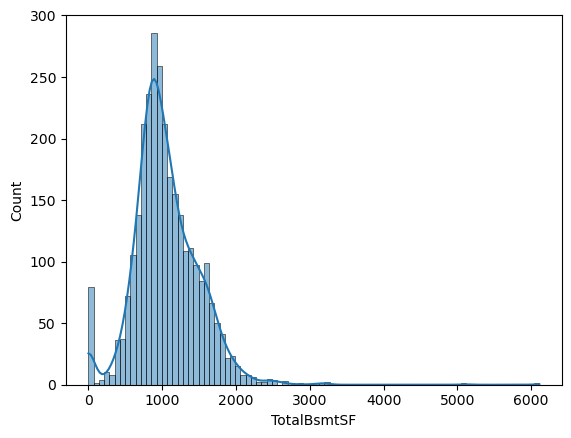

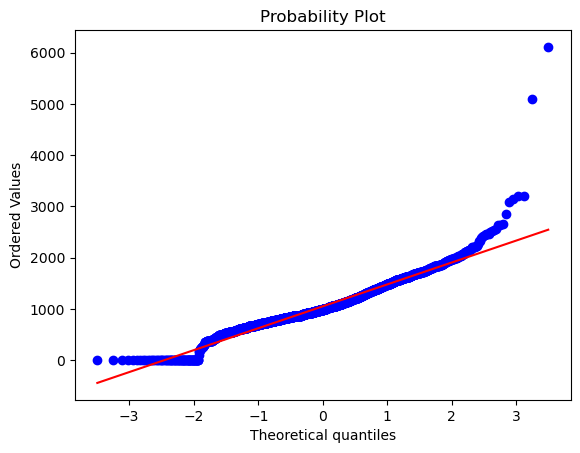

In [19]:
ax = sns.histplot(all_data["TotalBsmtSF"], kde=True)
plt.show()
ax = stats.probplot(all_data["TotalBsmtSF"], plot=plt)
plt.show()

This one is not too much skewed and is zero-inflated. So we won't transform it right now.

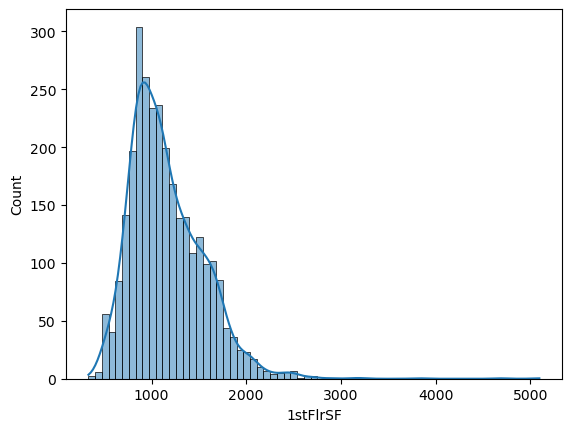

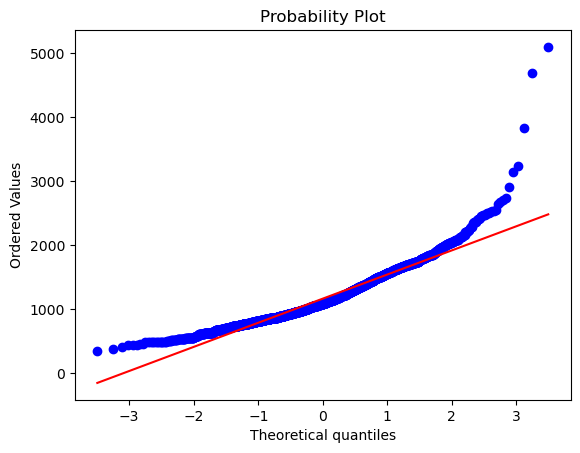

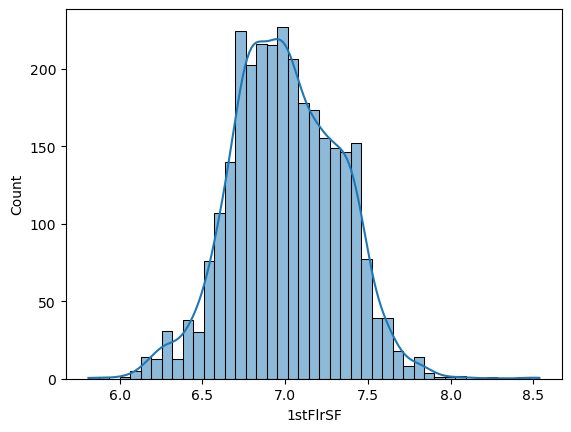

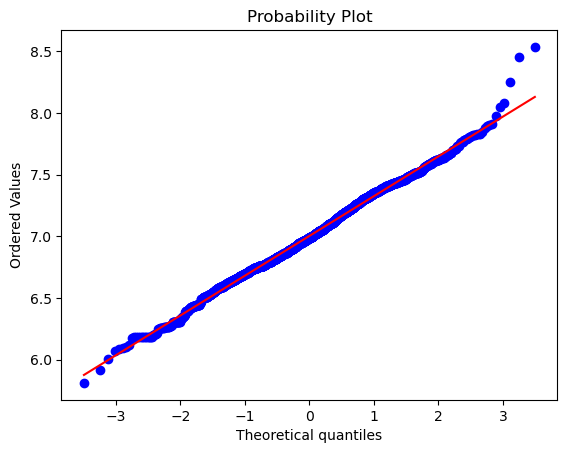

In [20]:
ax = sns.histplot(all_data["1stFlrSF"], kde=True)
plt.show()
ax = stats.probplot(all_data["1stFlrSF"], plot=plt)
plt.show()

all_data["1stFlrSF"] = np.log(all_data["1stFlrSF"])

ax = sns.histplot(all_data["1stFlrSF"], kde=True)
plt.show()
ax = stats.probplot(all_data["1stFlrSF"], plot=plt)
plt.show()

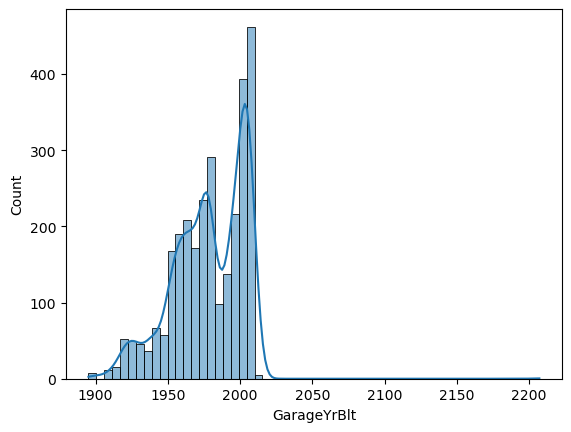

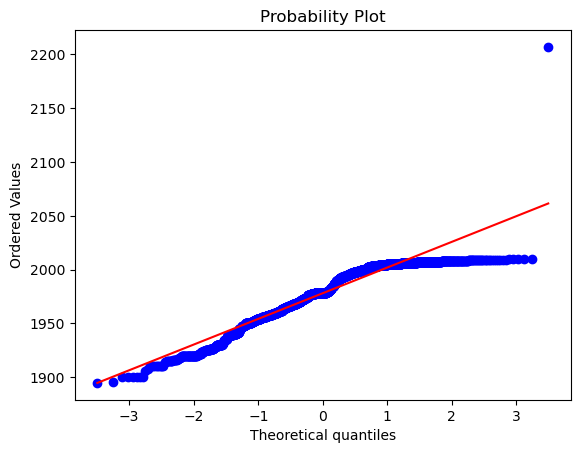

In [21]:
ax = sns.histplot(all_data["GarageYrBlt"], kde=True)
plt.show()
ax = stats.probplot(all_data["GarageYrBlt"], plot=plt)
plt.show()

In [22]:
print(all_data["GarageYrBlt"].max())

all_data.loc[all_data["GarageYrBlt"] > 2023, "GarageYrBlt"] = all_data["GarageYrBlt"].mean()

2207.0


Oops! There if a garage built in the future! This value was replaced with the variable average.

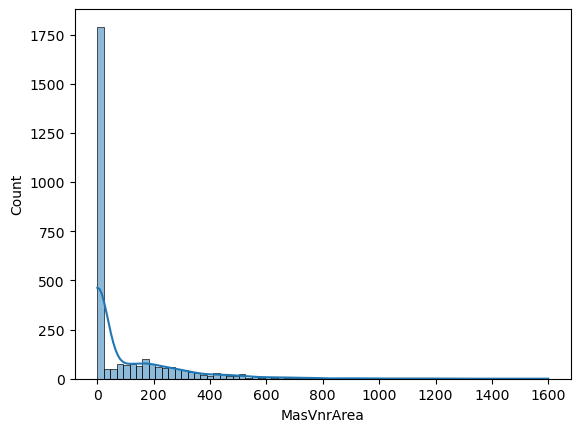

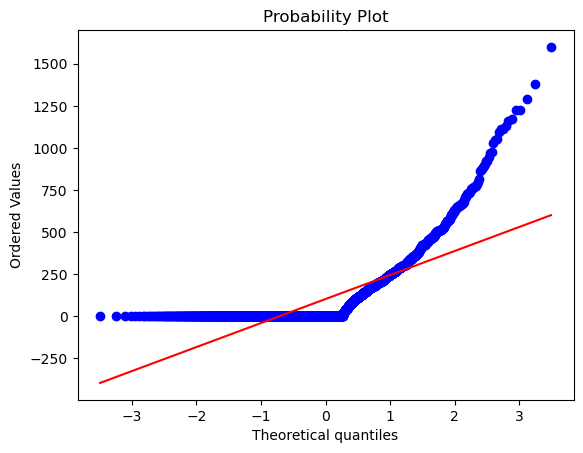

In [23]:
ax = sns.histplot(all_data["MasVnrArea"], kde=True)
plt.show()
ax = stats.probplot(all_data["MasVnrArea"], plot=plt)

Extreme zero-inflation. So let's keep it this way.

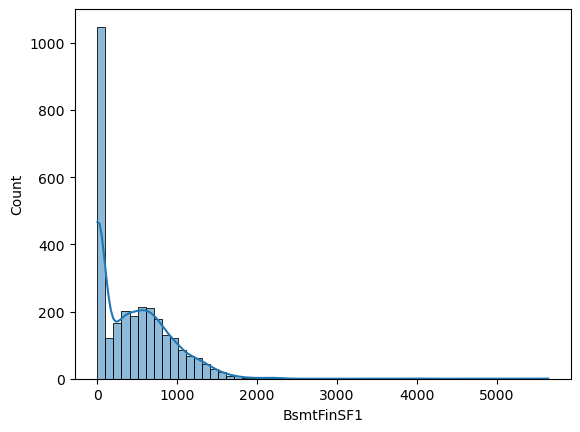

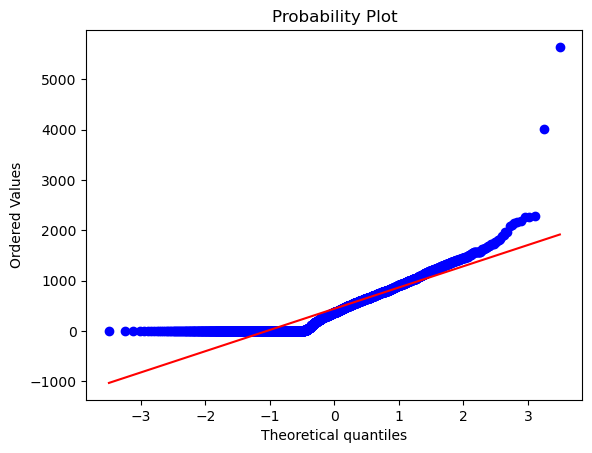

In [24]:
ax = sns.histplot(all_data["BsmtFinSF1"], kde=True)
plt.show()
ax = stats.probplot(all_data["BsmtFinSF1"], plot=plt)

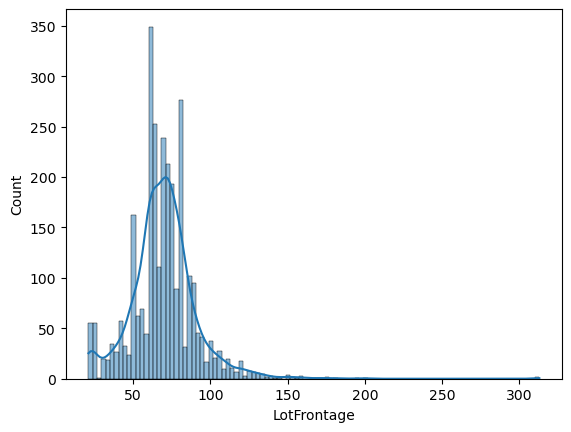

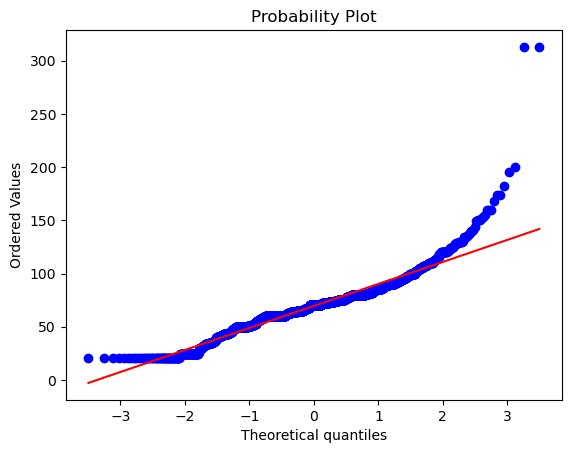

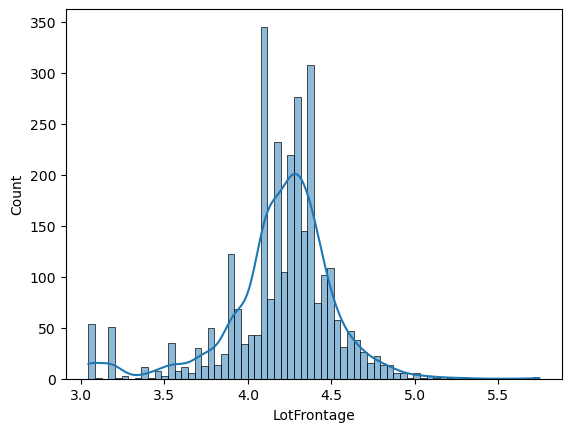

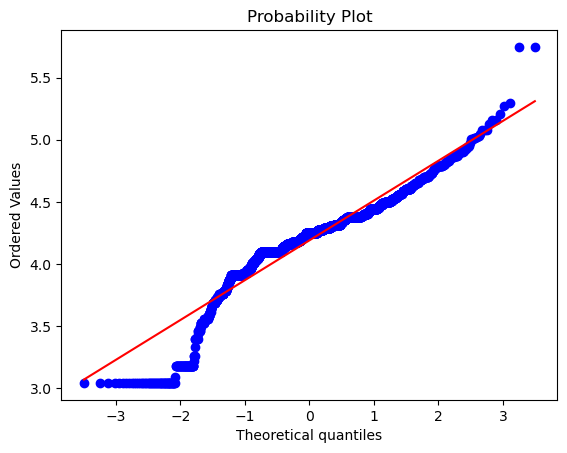

In [25]:
ax = sns.histplot(all_data["LotFrontage"], kde=True)
plt.show()
ax = stats.probplot(all_data["LotFrontage"], plot=plt)
plt.show()

all_data["LotFrontage"] = np.log(all_data["LotFrontage"])

ax = sns.histplot(all_data["LotFrontage"], kde=True)
plt.show()
ax = stats.probplot(all_data["LotFrontage"], plot=plt)
plt.show()

In [26]:

x_numeric_columns = numeric_columns.drop("SalePrice")
skewness = all_data[x_numeric_columns].apply(stats.skew)

# get most skewed variables
skewness = pd.DataFrame({"Skew": skewness.sort_values(key=lambda x: abs(x), ascending=False)})
skewness.head(10)

,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694
BsmtHalfBath,3.931594


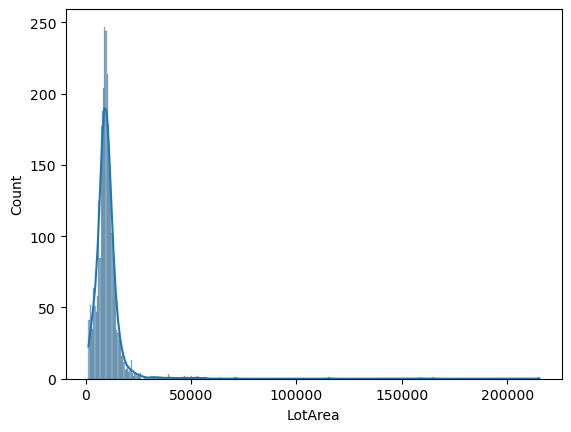

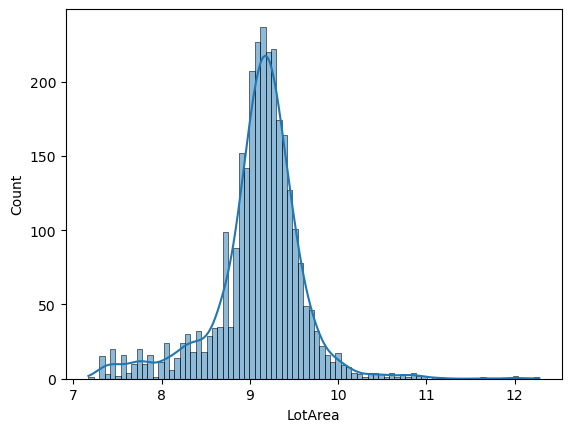

In [27]:
ax = sns.histplot(all_data["LotArea"], kde=True)
plt.show()


all_data["LotArea"] = np.log(all_data["LotArea"])

ax = sns.histplot(all_data["LotArea"], kde=True)
plt.show()

Besides this variable, all others are skewed due to lots of zeros. This is pretty common in this dataset, so let's create binary variables describing whether those variables are zero or not:

In [28]:
has_zero = all_data[x_numeric_columns].eq(0).any()
has_zero = has_zero[has_zero == True].index.values

for var in has_zero:
    all_data[f"Has{var}"] = (all_data[var] != 0).astype(int)

In [29]:
all_data = pd.get_dummies(all_data)

train_data = all_data[:n_train]
test_data = all_data[n_train:]

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


def cv_rmse(model):
    k_fold = KFold(n_splits=5, shuffle=True).get_n_splits(train_data.values)
    rmse = np.sqrt(
        -cross_val_score(
            model, train_data.values, y_train_log, scoring="neg_mean_squared_error", cv=k_fold
        )
    )
    return rmse

In [31]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

lasso = Lasso(alpha=0.0005)

elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

ridge = KernelRidge(alpha=0.5, kernel="linear")

gboost = GradientBoostingRegressor(n_estimators=250)

xgboost = xgb.XGBRegressor()


models = [lasso, elastic, ridge, gboost, xgboost]

for model in models:
    print(cv_rmse(model).mean(), cv_rmse(model).std())

0.1270289789000097 0.022972286565072282
0.12609038548204615 0.021254928928696924
0.13744198689215723 0.02177433935620816
0.1258867550893156 0.010321672124014462
0.13962440668606982 0.010476183917125294


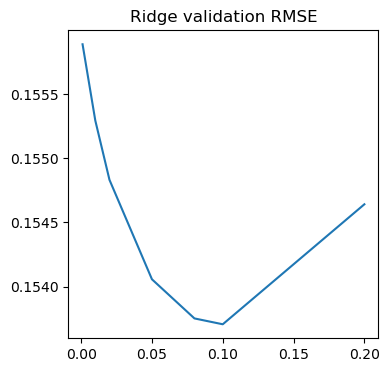

In [32]:
alphas = [1e-3, 1e-2, 2e-2, 5e-2, 8e-2, 1e-1, 2e-1]

cv_ridge = [
    cv_rmse(
    make_pipeline(RobustScaler(), KernelRidge(alpha, kernel="linear"))).mean()
    for alpha in alphas
]
cv_ridge = pd.Series(cv_ridge, index=alphas)
ax = cv_ridge.plot(title="Ridge validation RMSE", figsize=(4, 4))

In [33]:
ridge = make_pipeline(RobustScaler(), KernelRidge(alpha=0.1, kernel="linear"))
ridge = ridge.fit(train_data, y_train_log)

print(f"Ridge RMSE: {cv_rmse(ridge).mean():.4f}")

Ridge RMSE: 0.1537


/home/matheus/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.385e-02, tolerance: 1.800e-02
  model = cd_fast.enet_coordinate_descent(


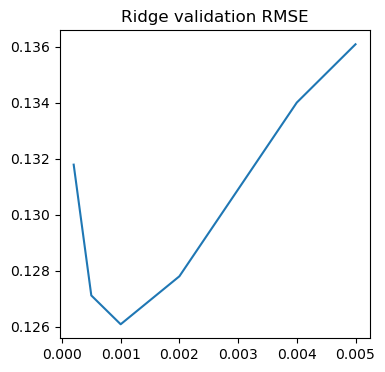

In [34]:
from sklearn.linear_model import ElasticNet

alphas = [2e-4, 5e-4, 1e-3, 2e-3, 4e-3, 5e-3]

cv_elastic = [
    cv_rmse(
    make_pipeline(RobustScaler(), ElasticNet(alpha=alpha))).mean()
    for alpha in alphas
]
cv_elastic = pd.Series(cv_elastic, index=alphas)
ax = cv_elastic.plot(title="Ridge validation RMSE", figsize=(4, 4))

elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=1e-3))

In [35]:
from sklearn.linear_model import LassoCV

alphas = [8e-5, 1e-4, 2e-4, 4e-4, 5e-4, 6e-4, 8e-4, 1e-3]

lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alphas)).fit(train_data, y_train_log)
print(f"Lasso RMSE: {cv_rmse(lasso).mean():.4f} | alpha = {lasso[1].alpha_}")

Lasso RMSE: 0.1269 | alpha = 0.0006


Let's check the most relevant predictors in out lasso regression model:

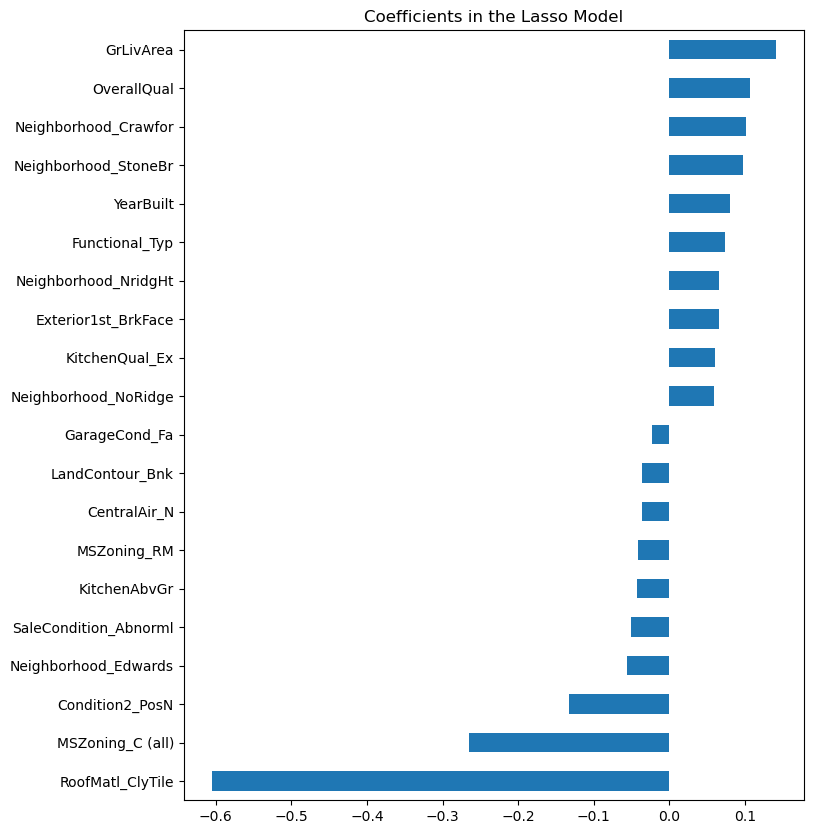

In [36]:
lasso_coef = pd.Series(lasso[1].coef_, index=train_data.columns)
imp_coef = pd.concat(
    [lasso_coef.sort_values().head(10), lasso_coef.sort_values().tail(10)]
)

plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
ax = plt.title("Coefficients in the Lasso Model")

In [37]:
import xgboost as xgb

xgboost = xgb.XGBRegressor(n_estimators=400, max_depth=2, learning_rate=0.1)

xgboost.fit(train_data, y_train_log)
print(f"XGBoost RMSE: {cv_rmse(xgboost).mean():.4f}")

XGBoost RMSE: 0.1244


In [38]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(
    objective="regression",
    num_leaves=5,
    learning_rate=0.05,
    n_estimators=400,
)

model_lgb.fit(train_data, y_train_log)
print(f"LightGBM RMSE: {cv_rmse(model_lgb).mean():.4f}")


LightGBM RMSE: 0.1276


Now, let's ensemble the models together using a strategy borrowed from here: https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

In [39]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone


class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [40]:
from sklearn.linear_model import LinearRegression

meta_model = LinearRegression()
lasso = Lasso(alpha=6e-4)

stacked_models = StackingAveragedModels(
    base_models=[lasso, ridge, elastic, xgboost, model_lgb], meta_model=meta_model
)

print(f"Ensemble RMSE: {cv_rmse(stacked_models).mean():.4f}")


Ensemble RMSE: 0.1240


Let's finally train with all of our training data and make the test predictions:

In [41]:
xgboost.fit(train_data, y_train_log)
train_xgb_pred = xgboost.predict(train_data)
test_xgb_pred = xgboost.predict(test_data)

print(f"Train XGB RMSE: {np.sqrt(mean_squared_error(train_xgb_pred, y_train_log)):.4f}")

Train XGB RMSE: 0.0770


In [42]:
model_lgb.fit(train_data, y_train_log)
train_lgb_pred = model_lgb.predict(train_data)
test_lgb_pred = model_lgb.predict(test_data)

print(f"Train LGB RMSE: {np.sqrt(mean_squared_error(train_lgb_pred, y_train_log)):.4f}")

Train LGB RMSE: 0.0888


In [43]:
stacked_models.fit(train_data.values, y_train_log)
train_stacked_pred = stacked_models.predict(train_data.values)
test_stacked_pred = stacked_models.predict(test_data.values)

print(f"Train ensenble RMSE: {np.sqrt(mean_squared_error(train_stacked_pred, y_train_log)):.4f}")

Train ensenble RMSE: 0.0889


Well, our XGBoost model is better than the ensemble. Sometimes, XGBoost is all you need. Let's create our submission CSV file.

In [44]:
submission = pd.DataFrame(
    {"Id": test_data["Id"], "SalePrice": np.exp(test_lgb_pred)}
)
submission.to_csv("./data/submission.csv", index=False)